Neural network for importance sampling supplemented variational inference.

## Motivation

As the visualization of shallow neural network on MNIST dataset shows, the fitting of the PDF of the posterior via variational inference needs further finization. This calls for adding more (trainable) degree of freedom to the inferencer. At the same time, however, we shall keep both the PDF and the sampler of the inference-distribution explicit. Thus, the approach of adding these degree of freedom onto the parameterization of the inference-distribution would be too hard to establish. Instead, we decide to add them onto the weights of the samples sampled from the inference-distribution, thus treat this approach as an importance-sampling.

(Furthermore, the weight is a map from the parameter-space to $\mathbb{R}$, which thus avoids the redundancy of degree of freedom as the approach of neural network sampler (which maps from some low-dimensional hidden space to the high-dimensional parameter-space).)

## Theory

### Loss-function

Let $\theta \in \mathbb{R}^{N_d}$ the parameters, and $p(\theta)$ the PDF of the posterior over the parameter-space. Let $q(\theta; z)$ the inference distribution, with parameter $z$ to be trained. Let
\begin{equation}
  \hat{q}(\theta; z, w) := \omega (\theta; w) q(\theta, z),
\end{equation}
where $\omega (\theta; w)$, mapping to $\mathbb{R}$, is the weights of the importance sampling, with parameter $w$ to be trained.

The loss-function is
\begin{align}
  \mathcal{L} (z, w)
    & := \textrm{KL}(\hat{q} \| p) \\
    & = \int \hat{q} (\theta)
          \left[ \ln \hat{q} (\theta; z, w) - \ln p (\theta) \right]
        d \theta \\
    & = \int q(\theta) \omega (\theta; w)
          \left[ \ln \omega (\theta; w) + \ln q (\theta; z)
                 - \ln p (\theta) \right]
        d \theta \\
    & = \mathbb{E}_{\theta_s \sim q(z)}
          \left\{ \omega (\theta_s; w)
            \left[ \ln \omega (\theta_s; w) + \ln q (\theta_s; z)
                   - \ln p (\theta_s) \right] \right\},
\end{align}
where $s = 1, \ldots, N_s$. Further, for $\theta \in \{\theta_1, \ldots, \theta_{N_s}\} \sim q(z)$, let
\begin{equation}
  \omega(\theta; w) := \textrm{softmax} \left( \zeta (\theta; w) \right) * N_s,
\end{equation}
the normalization of $\hat{q}(\theta; z, w)$ can always be ensured:
\begin{align}
  1 & = \int \hat{q}(\theta; z, w) d\theta \\
    & = \mathbb{E}_{\theta_s \sim q(z)} \left[ \omega (\theta; w) \right] \\
    & = N_s * \mathbb{E}_{\theta_s \sim q(z)}
                \left[ \textrm{softmax} \left( \zeta (\theta; w) \right) \right] \\
    & = N_s * \frac{1}{N_s}
        \sum_s \textrm{softmax}_s \left( \zeta (\theta; w) \right) \\
    & = N_s \frac{1}{N_s} \times 1.
\end{align}

This methods extends the representability of pure variational inference by adding a weight-function. This weight-function can be implemented by a neural network by the utility of its universality.

We do not prefer a large variance of the weights, thus a penalty on this variance in the loss is called for. Thus
\begin{align}
  \mathcal{L}(z, w)
    & \to \mathcal{L}(z, w; \sigma) \\
    & = \mathbb{E}_{\theta_s \sim q(z)}
          \left\{ \omega (\theta_s; w)
            \left[ \ln \omega (\theta_s; w) + \ln q (\theta_s; z)
                   - \ln p (\theta_s) \right] \right\} \\
     & + \mathbb{E}_{\theta_s \sim q(z)}
           \left\{ \left(
             \frac{ \omega(\theta_s; w) - 1 }{ \sigma }
             \right)^2 \right\},
\end{align}
where $\sigma$ is a hyper-parameter.

The machine will automatically minimizes this loss by tuning the trainable parameters $(z, w)$, and then find a "harmonic" way of combining the $\omega$ and $q$, so as to represent the target $p(\theta)$.

### Measurement of Performance

The performance of the inference can be measured explicitly. For each sample $\theta$, define error:
\begin{equation}
  \mathcal{E} (\theta; z, w)
    := \ln p(\theta) - \ln q(\theta, z) - \ln \omega(\theta, w).
\end{equation}
If the inference works, we would expect that the $\{\mathcal{E}(\theta_s) \mid s = 1, \ldots, N_s\}$ distributes around the zero-point.

This measurement of performance can also help us in fine-tuning the hyper-parameters, like the $\sigma$, or those in the optimization process.

## Implementation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfd
from collections import namedtuple
from uba.utils.math import softplus

In [2]:
LossInfo = namedtuple('LossInfo',
    ('samples, sample_logits, weights, log_weights, log_ps,'
      'log_qs, kl_divergence, weight_penalty, loss, errors'))

def make_loss(log_p, inference_dist, logits,
              logits_scale=1.0, n_samples=10):
  """
  Args:
    log_p: Callable from tensor of the shape `[n_dims]` to scalar.
    inference_dist: An instance of `tfd.Distribution`.
    logits: Callable from tensor of the shape `[n_samples, n_dims]`
      to tensor of the shape `[n_samples]`.
    logits_scale: Positive float.
    n_samples: Positive integer.
  Returns:
    An instance of `LossInfo`.
  """
  with tf.name_scope('Samples'):
    # shape `[n_samples, n_dims]`
    samples = inference_dist.sample(n_samples)
  with tf.name_scope('Logits'):
    # shape: `[n_samples]`
    sample_logits = logits(samples)
  with tf.name_scope('KLDivergence'):
    # shape: `[n_samples]`
    weights = tf.nn.softmax(sample_logits) * n_samples
    # shape: `[n_samples]`
    log_weights = tf.log(weights)
    # The batch-supplement may not ensured in `log_p`,
    # so we employ `tf.map_fn` for vectorization
    # shape: `[n_samples]`
    log_ps = tf.map_fn(log_p, samples)
    # Notice `tfd.Distribution.log_prob()` is batch-supplemented,
    # shape: `[n_samples]`
    log_qs = inference_dist.log_prob(samples)
    # shape: `[]`
    kl_divergence = tf.reduce_mean(
      weights * (log_weights + log_qs - log_ps),
      axis=0)
  with tf.name_scope('WeightPenalty'):
    # shape: `[n_samples]`
    delta_weights = (weights - 1.0) / logits_scale
    # shape: `[]`
    weight_penalty = tf.reduce_mean(tf.square(delta_weights), axis=0)
  with tf.name_scope('Loss'):
    # shape: `[]`
    # loss = kl_divergence + weight_penalty
    loss = kl_divergence * (1.0 + weight_penalty)
  with tf.name_scope('Errors'):
    # shape: `[n_samples]`
    errors = log_ps - log_qs - log_weights
  return LossInfo(samples, sample_logits, weights, log_weights, log_ps,
                  log_qs, kl_divergence, weight_penalty, loss, errors)

## Experiments

### High-dimensional Gaussian distribution

Set up graph

In [3]:
tf.reset_default_graph()

The target is the PDF of distribution
$\mathcal{N} \left(0, \textrm{softplus}(10)\right)$
on $\mathbb{R}^{N_d}$.

In [4]:
n_dims = 10000
target_dist = tfd.Independent(
    tfd.NormalWithSoftplusScale(loc=tf.zeros(n_dims),
                                scale=10*tf.ones(n_dims)))

In [5]:
with tf.name_scope('InferenceDistribution'):
  loc = tf.get_variable('loc', [n_dims], 'float32')
  scale = tf.get_variable('scale', [n_dims], 'float32')
  inference_dist = tfd.Independent(
      tfd.NormalWithSoftplusScale(loc, scale))

def logits(samples, n_hiddens=5):
  """The `logits` argument of `make_loss()`."""
  with tf.name_scope('LogitsNeuralNetwork'):
    # shape: `[n_samples, n_hiddens]`
    hiddens = tf.layers.dense(samples, n_hiddens,
                              activation=tf.nn.leaky_relu)
    # shape: `[n_samples, 1]`
    outputs = tf.layers.dense(hiddens, 1)
    # shape: `[n_samples]`
    return tf.squeeze(outputs, axis=1)

In [6]:
loss_info = make_loss(target_dist.log_prob, inference_dist, logits,
                      logits_scale=10.0)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss_info.loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Training

Loss (before): 21837.0
Loss (after): 0.115946
Weight penalty (after): 0.000116328


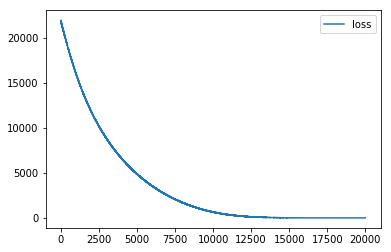

In [7]:
print('Loss (before):', sess.run(loss_info.loss))

loss_vals = []
n_iters = 20000
for step in range(1, n_iters+1):
  sess.run(train_op)
  
  # The value of loss can sometimes temporally be `NaN`, and in
  # the next `sess.run()` becomes non-`NaN` (strange!). So, we
  # employ the following strategy:
  loss_val = sess.run(loss_info.loss)
  n_trials = 0
  while np.isnan(loss_val) and n_trials < 10:
    loss_val = sess.run(loss_info.loss)
    n_trials += 1
    if n_trials == 9:
      print(sess.run([loss_info.log_weights, loss_info.log_ps,
                      loss_info.log_qs, loss_info.kl_divergence,
                      loss_info.weight_penalty]))
  if n_trials == 9:
    print('Always `NaN`, finally stopped at step {}.'.format(step))
    break  
  loss_vals.append(loss_val)
  
print('Loss (after):', sess.run(loss_info.loss))
print('Weight penalty (after):', sess.run(loss_info.weight_penalty))

# Visualize
plt.plot(loss_vals, label='loss')
plt.legend()
plt.show()

Visualize the trained results

In [8]:
samples = []
log_weights = []
errors = []
for i in range(100):
  result = sess.run([loss_info.samples, loss_info.log_weights,
                     loss_info.errors])
  sample_vals, log_weight_vals, error_vals = result
  samples += [_ for _ in sample_vals]
  log_weights += [_ for _ in log_weight_vals]
  errors += [_ for _ in error_vals]
samples = np.array(samples)
log_weights = np.array(log_weights)
errors = np.array(errors)

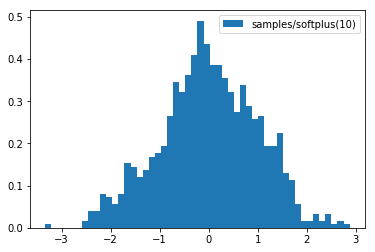

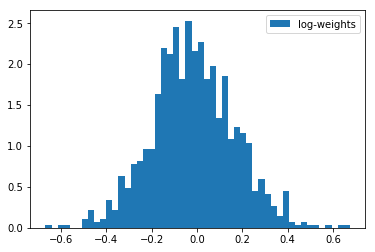

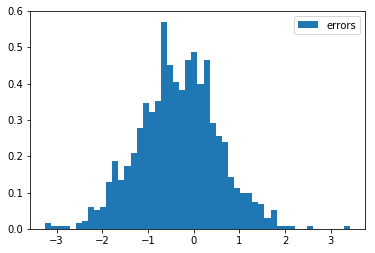

In [9]:
plt.hist(samples[:,0]/softplus(10), bins=50, density=True,
         label='samples/softplus(10)')
plt.legend()
plt.show()

plt.hist(log_weights, bins=50, density=True,
         label='log-weights')
plt.legend()
plt.show()

plt.hist(errors, bins=50, density=True,
         label='errors')
plt.legend()
plt.show()

* Conclusion: so far so good.